In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# torch.manual_seed(1)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import pickle

In [4]:
import os
if not os.path.exists("weights_batched/"):
    os.mkdir("weights_batched/")
        

In [5]:

hidden_size = 2048 # randomly chosen
output_size = 1 # we want it to return a number that can be used to calculate the difference from the actual number

class NeuralNetwork(nn.Module):
    def __init__(self,img_dim, output_size):
        
        super(NeuralNetwork, self).__init__()
        
        
        # weights 
#         self.W = torch.randn(img_dim,img_dim , requires_grad=True)
#         self.theta_D = torch.randn(num_img, img_dim, requires_grad=True)
        
        
        self.W = nn.Linear(img_dim,img_dim)
        
        self.discriminator_thetaD = nn.Linear(img_dim,hidden_size)
        self.discriminator_hiddn = nn.Linear(hidden_size,hidden_size)
        self.discriminator_hiddn2 = nn.Linear(hidden_size,output_size)
        self.activ = nn.LeakyReLU()

        
# Add bias
#         self.b1 = torch.randn(img_dim, requires_grad=True)
#         self.b2 = torch.randn(hidden_size, requires_grad=True)
#         self.b3 = torch.randn(output_size, requires_grad=True)
        
        
    def forward(self, inp_matrix,phase='Discriminate',typeinp='img',d_flag=True):
        
        if phase == 'Discriminate' and typeinp=='img':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            self.discriminator_hiddn2.trainable = True
            
            
            wTx = self.W(inp_matrix)

            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            
            discriminator_hidden_in = self.activ(discriminator_hidden_in)
            
            out1 = self.discriminator_hiddn(discriminator_hidden_in)
            
            out1 = self.activ(out1)
            
            out = self.discriminator_hiddn2(out1)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Discriminate' and typeinp=='text':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            self.discriminator_hiddn2.trainable = True
            
#             wTx = self.W(img)

            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            discriminator_hidden_in = self.activ(discriminator_hidden_in)

            out1 = self.discriminator_hiddn(discriminator_hidden_in)
            out1 = self.activ(out1)

            out = self.discriminator_hiddn2(out1)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Map' and typeinp=='img' :
            
            self.W.trainable = True
            
            wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = d_flag
            self.discriminator_hiddn.trainable = d_flag
            self.discriminator_hiddn2.trainable = d_flag
            
            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            discriminator_hidden_in = self.activ(discriminator_hidden_in)

            out1 = self.discriminator_hiddn(discriminator_hidden_in)
            out1 = self.activ(out1)

            out = self.discriminator_hiddn2(out1)
            out = out.view(-1)
            return nn.Sigmoid()(out)
            
        if phase == 'Map' and typeinp=='text' :
            self.W.trainable = True
            
#             wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = d_flag
            self.discriminator_hiddn.trainable = d_flag
            self.discriminator_hiddn2.trainable = d_flag
            
            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            discriminator_hidden_in = self.activ(discriminator_hidden_in)
            out1 = self.discriminator_hiddn(discriminator_hidden_in)
            out1 = self.activ(out1)            
            out = self.discriminator_hiddn2(out1)
            out = out.view(-1)
            return nn.Sigmoid()(out)

            


In [6]:
dimension_space = 300

nne = NeuralNetwork(dimension_space,1).cuda()

In [7]:

learning_rate = 0.1

# create a stochastic gradient descent optimizer
# optimizer = optim.SGD(nne.parameters(), lr=learning_rate, momentum=0.95)

# optimizer = optim.Adam([var1, var2], lr = 0.0001)

optimizer = optim.Adam(nne.parameters(), lr = 0.0001)

# create a loss function
criterion = nn.BCELoss().cuda()

In [8]:
nne

NeuralNetwork(
  (W): Linear(in_features=300, out_features=300, bias=True)
  (discriminator_thetaD): Linear(in_features=300, out_features=2048, bias=True)
  (discriminator_hiddn): Linear(in_features=2048, out_features=2048, bias=True)
  (discriminator_hiddn2): Linear(in_features=2048, out_features=1, bias=True)
  (activ): LeakyReLU(negative_slope=0.01)
)

In [9]:
import numpy as np

# num_instances = 30000

# input_img = np.random.rand(num_instances,300)
# input_text = np.random.rand(num_instances,300)


np.random.seed(9)

with open("ques_matrix.pickle","rb") as fh:
    input_text = pickle.load(fh)

pickup_shuffler = np.random.randint(0, len(input_text), len(input_text))



with open("imgs_matrix.pickle","rb") as fh:
    input_img = pickle.load(fh)

input_img = input_img[pickup_shuffler]
input_text = input_text[pickup_shuffler]    

num_instances = len(input_img)

In [10]:
num_instances


48392

In [11]:
input_img

array([[-7.0355387 ,  2.192201  ,  0.70348793, ...,  0.1225921 ,
        -0.13015182, -0.35766512],
       [-0.08161107, -0.06283023, -1.6356022 , ...,  0.578129  ,
        -0.21244498,  0.70294553],
       [ 6.8928294 ,  2.0406528 , -2.3916461 , ..., -0.29088953,
        -0.05617349,  0.0300037 ],
       ...,
       [ 2.7322083 ,  0.89482135,  2.0747082 , ...,  0.15937011,
         0.3848007 , -0.42230788],
       [ 1.7304292 ,  1.1774589 , -5.500091  , ..., -0.21041736,
        -0.2576633 ,  0.2472547 ],
       [-0.9874369 , -4.0450964 ,  1.6803837 , ..., -0.21229023,
         0.05216914, -0.18722685]], dtype=float32)

In [12]:
num_epochs = 20

In [13]:
from tqdm import tqdm_notebook
from time import sleep


In [14]:
def plot_loss(a,b,c,d=None):
    fig=plt.figure()
    
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot([i for i in range(len(a))],a,label='discriminator image loss')
    plt.plot([i for i in range(len(b))],b,label='discriminator text loss')
    plt.plot([i for i in range(len(c))],c,label='mapper loss')
    # plt.plot([i for i in range(num_epochs)],mapper_text_loss,label='mapper text loss')
    plt.legend(loc='upper right')

In [15]:
discriminator_img_loss = []
discriminator_text_loss = []
mapper_loss = []
mapper_text_loss = []

plt_discriminator_img_loss = []
plt_discriminator_text_loss = []
plt_mapper_loss = []
plt_mapper_text_loss = []




In [16]:
smoothing = 0.2

In [17]:
batch_size = 256
import math
num_steps = math.ceil(num_instances/batch_size)

In [18]:
for epoch in tqdm_notebook(range(num_epochs),desc='Epochs'):
    
    for step in tqdm_notebook(range(num_steps),desc='Step',leave=False):
    
        ## Discriminate. For image, it is 1, saying it comes from different distribution
        
        input_given = input_img[step*batch_size:(step+1)*batch_size]
        outed = nne( Variable(torch.from_numpy(input_given)).cuda().float(),phase='Discriminate',typeinp='img')
        targets = (torch.ones(len(input_given)).cuda()).fill_(1- smoothing)  # Smoothing suggested by GoodFellow
        loss = criterion(outed,targets)
        discriminator_img_loss.append(loss.cpu().tolist())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        ## Discriminate. For text, it is 0 saying it is text, from same distribution 
        input_given = input_text[step*batch_size:(step+1)*batch_size]
        outed = nne( Variable(torch.from_numpy(input_given)).cuda().float(),phase='Discriminate',typeinp='text')
        targets = (torch.zeros(len(input_given)).cuda()).fill_(smoothing)
        loss = criterion(outed,targets)
        discriminator_text_loss.append(loss.cpu().tolist())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        ## Mapper , Training in a way to fool discriminator think that vector from image distribution is from text distribution. 
        
        input_given = input_img[step*batch_size:(step+1)*batch_size]
        outed = nne( Variable(torch.from_numpy(input_given)).cuda().float(),phase='Map',typeinp='img',d_flag=True)
        targets = (torch.zeros(len(input_given)).cuda()).fill_(smoothing)
        loss = criterion(outed,targets)
        mapper_loss.append(loss.cpu().tolist())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        
        ## Mapper , Training in a way to fool discriminator think that vector from text distribution is from image distribution. 
        
#         input_given = input_img[step*batch_size:(step+1)*batch_size]
#         outed = nne( Variable(torch.from_numpy(input_given)).cuda().float(),phase='Map',typeinp='text')
#         loss = criterion(outed,torch.ones(num_instances).cuda())
#         mapper_text_loss.append(loss.cpu().tolist())
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

    plt_discriminator_img_loss.append(discriminator_img_loss[-1])
    plt_discriminator_text_loss.append(discriminator_text_loss[-1])
    plt_mapper_loss.append(mapper_loss[-1])
    

In [19]:
discriminator_img_loss[-5:],discriminator_text_loss[-5:],mapper_loss[-5:]

([0.6930667161941528,
  0.6930744647979736,
  0.6930619478225708,
  0.6930395364761353,
  0.6929448246955872],
 [0.5004323720932007,
  0.500425398349762,
  0.5004228353500366,
  0.5004276633262634,
  0.5004048347473145],
 [0.6933573484420776,
  0.6933489441871643,
  0.6933616399765015,
  0.6933887004852295,
  0.6939176321029663])

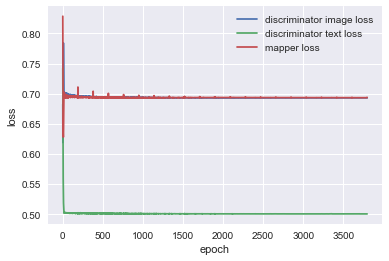

In [20]:
fig=plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot([i for i in range(len(discriminator_img_loss))],discriminator_img_loss,label='discriminator image loss')
plt.plot([i for i in range(len(discriminator_text_loss))],discriminator_text_loss,label='discriminator text loss')
plt.plot([i for i in range(len(mapper_loss))],mapper_loss,label='mapper loss')
# plt.plot([i for i in range(num_epochs)],mapper_text_loss,label='mapper text loss')
plt.legend(loc='upper right')

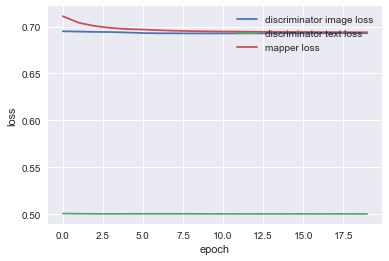

In [22]:
fig=plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot([i for i in range(num_epochs)],plt_discriminator_img_loss,label='discriminator image loss')
plt.plot([i for i in range(num_epochs)],plt_discriminator_text_loss,label='discriminator text loss')
plt.plot([i for i in range(num_epochs)],plt_mapper_loss,label='mapper loss')
# plt.plot([i for i in range(num_epochs)],mapper_text_loss,label='mapper text loss')
plt.legend(loc='upper right')

# Saving current model and states

In [46]:
if not os.path.exists('Plots/epochs_{}'.format(num_epochs)):
    os.mkdir('Plots/epochs_{}'.format(num_epochs))

fig.savefig('Plots/epochs_{}/train_thetaD_NoTextGen_{}BZ_{}smooth.png'.format(num_epochs,batch_size,smoothing), bbox_inches='tight')

In [47]:
torch.save(nne,"weights_batched/model_{}mapperloss_{}discImg_{}epoch__{}BZ_{}smooth".format(mapper_loss[-1],discriminator_img_loss[-1],num_epochs,batch_size,smoothing))

C:\Users\kmura\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NeuralNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
W_matrix = nne.W.weight.data.tolist()
W_matrix = np.array(W_matrix)
with open("weights_batched/W_matrix_{}mapperloss_{}discImg_{}epoch_{}BZ_{}smooth.pickle".format(mapper_loss[-1],discriminator_img_loss[-1],num_epochs,batch_size,smoothing),"wb") as fh:
    pickle.dump(W_matrix,fh)

# Testing and inferences

In [ ]:
with open("weights_batched/W_matrix_{}mapperloss_{}discImg_{}epoch_{}BZ_{}smooth.pickle".format(mapper_loss[-1],discriminator_img_loss[-1],num_epochs,batch_size,smoothing),"rb") as fh:
    W_matrix = pickle.load(W_matrix)

In [23]:
W_matrix = nne.W.weight.data.tolist()
W_matrix = np.array(W_matrix)

In [24]:
pickup_shuffler

array([20828,   501, 22584, ..., 35933, 39064, 21027])

In [25]:
with open("meta_imgs.pickle","rb") as fh:
    meta_imgs_pre = pickle.load(fh)

with open("meta_ques.pickle","rb") as fh:
    meta_ques_pre = pickle.load(fh)

meta_imgs=[]
meta_ques = []

for i in pickup_shuffler:
    meta_imgs.append(meta_imgs_pre[i])
    meta_ques.append(meta_ques_pre[i])



In [26]:
with open("img_id_file_map.pickle","rb") as fh:
    img_id_file_map= pickle.load(fh)

In [27]:
import cv2 

In [28]:
# definition to show original image and reconstructed image
def showOrigDec(orig, quesstions,before,after,num=3):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(40, 20))

    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i+1)
        plt.imshow(orig[i])
        ax.text(0.5,-0.4, str(i+1)+". "+ quesstions[i]+"\n\nBefore map :  "+str(before[i])+"\nAfter map :  "+str(after[i]), size=30, ha="center", transform=ax.transAxes)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    plt.show()

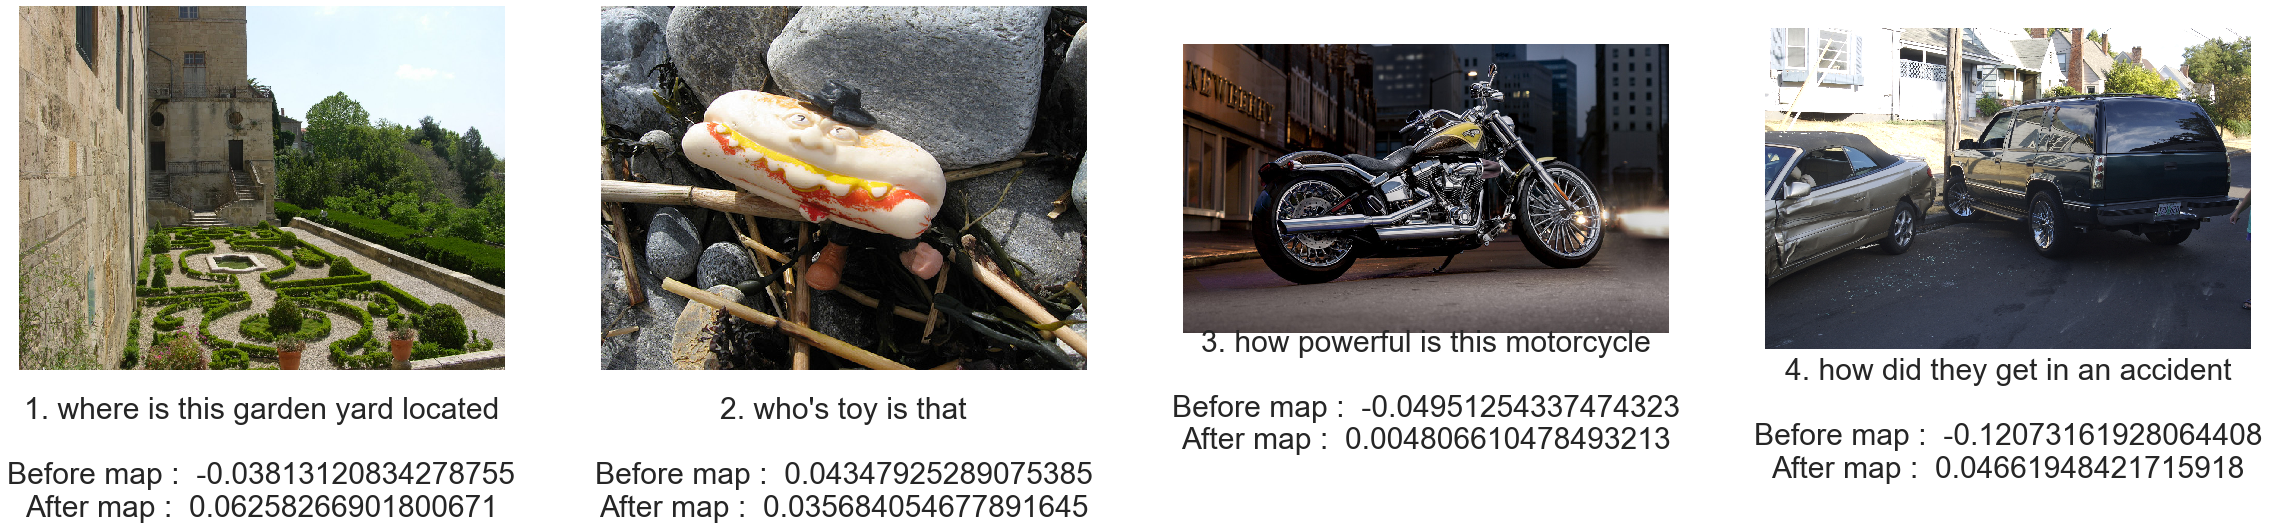

In [29]:
lbound = 89
num = 4

meta_img_test = meta_imgs[lbound :lbound + num]
meta_que_test = meta_ques[lbound :lbound + num]



parent_folder = "D:/SEM_7/Core_Project/MyCode/"
img_folder = "VQG/Image-Captioning/VQg_Dataset/VQG_Dataset/"

generatedImages = [ cv2.cvtColor(cv2.imread(parent_folder+img_folder+img_id_file_map[img_id]), cv2.COLOR_BGR2RGB) for img_id in meta_img_test]

x_img = input_img[lbound :lbound + num]
y_text = input_text[lbound :lbound + num]

from sklearn.metrics.pairwise import cosine_similarity



before_cosine_sim = []
for i in range(num):
    img_vec = x_img[i].reshape(1,-1)
    txt_vec = y_text[i].reshape(1,-1)
    before_cosine_sim.append(cosine_similarity(img_vec,txt_vec)[0][0])



after_cosine_sim = []
x_chang = np.matmul(x_img,W_matrix)

for i in range(num):
    img_vec = x_chang[i].reshape(1,-1)
    txt_vec = y_text[i].reshape(1,-1)
    after_cosine_sim.append(cosine_similarity(img_vec,txt_vec)[0][0])
    

    
showOrigDec(generatedImages,meta_que_test,before_cosine_sim,after_cosine_sim,num)



## tSNE demo

In [ ]:
from sklearn.manifold import TSNE


In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')


In [ ]:
import numpy as np
# test_inp = np.random.rand(1000,300)

In [ ]:
tsne_lda = tsne_model.fit_transform(input_text)

In [ ]:
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [ ]:
num_example = test_inp.shape[0]
title='visual trials'
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],source=bp.ColumnDataSource({"content": test_inp,}))



In [ ]:
# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, '{}.html'.format(title))

# Just checking the updatability property

In [ ]:
outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate')

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight

In [ ]:
nne.discriminator_hiddn.weight

In [ ]:
outed.shape

In [ ]:
loss = criterion(outed,torch.ones(1000))
loss.backward()
optimizer.step()

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight